[INFO] repo_path added to sys.path: /eos/home-s/sraj/Work_/CUA_20--/Analysis/output_root/v3_production/samples/postEE
[WARN] Import failed: No module named 'normalisation'
[WARN] Using fallback stubs for getXsec/getLumi (return 1.0)
Checking: ../../../output_root/v3_production/samples/postEE/GJetPt40.parquet
rows approx: 70891
sum(weight) = 0.0036229353233498507
sum(weight_central) = 72570.03470910339
ratio sum(w)/sum(wc) = 4.9923295997754004e-08
xsec (pb) = 1.0 lumi (fb^-1) = 1.0
expected_yield (sum(weight)*xsec*lumi) = 3.6229353233498505
expected_yield (sum(weight)/sum(weight_central) * xsec * lumi) ~ 4.992329599775401e-05


====Signal(NMSSM)========
Checking: ../../../output_root/v3_production/samples/postEE/NMSSM_X1000_Y125.parquet
rows approx: 678
sum(weight) = 0.5533337909691362
sum(weight_central) = 708.8191846433396
ratio sum(w)/sum(wc) = 0.0007806416685061369
xsec (pb) = 1.0 lumi (fb^-1) = 1.0
expected_yield (sum(weight)*xsec*lumi) = 553.3337909691362
expected_yield (sum(weigh

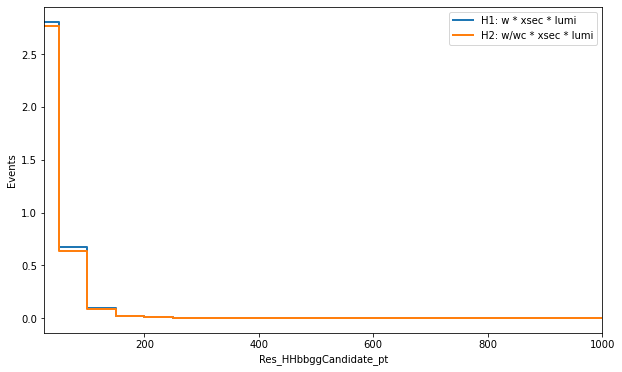

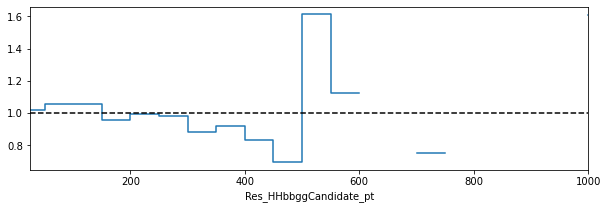

In [10]:
import sys, os
import numpy as np
import pyarrow.parquet as pq
import awkward as ak
import sys, os, numpy as np, awkward as ak, pyarrow.parquet as pq
import matplotlib.pyplot as plt

# explicit absolute path resolved from the relative path you gave
relative_repo = "../../../output_root/v3_production/samples/postEE/"
repo_path = os.path.abspath(relative_repo)
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)
print("[INFO] repo_path added to sys.path:", repo_path)

# attempt import
try:
    from normalisation import getXsec, getLumi
    print("[INFO] Imported getXsec/getLumi from normalisation")
except Exception as e:
    print(f"[WARN] Import failed: {e}")
    def getXsec(_): return 1.0
    def getLumi(year, era): return 1.0
    print("[WARN] Using fallback stubs for getXsec/getLumi (return 1.0)")
    
def compare_hist(parquet_path, varname="Res_M_X", 
                 nbins=40, lo=0, hi=2000, year="2023", era="postEE"):
    
    print(f"\n=== Comparing histograms for: {varname} ===")
    
    # -----------------------------
    # Load parquet
    # -----------------------------
    pqf = pq.ParquetFile(parquet_path)
    
    # read only needed columns to save memory
    needed_cols = [varname, "weight", "weight_central"]
    available = set(pqf.schema.names)
    missing = [c for c in needed_cols if c not in available]
    if missing:
        raise RuntimeError(f"Missing columns in file: {missing}")

    vals_all = []
    w_all    = []
    wc_all   = []

    for batch in pqf.iter_batches(batch_size=200000, columns=needed_cols):
        arr = ak.from_arrow(batch)

        vals = ak.to_numpy(arr[varname])
        w    = ak.to_numpy(arr["weight"])
        wc   = ak.to_numpy(arr["weight_central"])

        # clean NaNs
        good = np.isfinite(vals)
        vals = vals[good]
        w    = w[good]
        wc   = wc[good]

        vals_all.append(vals)
        w_all.append(np.where(np.isfinite(w), w, 0.0))
        wc_all.append(np.where(np.isfinite(wc), wc, 1.0))

    vals = np.concatenate(vals_all)
    w    = np.concatenate(w_all)
    wc   = np.concatenate(wc_all)

    # -----------------------------
    # Normalisation
    # -----------------------------
    xsec = float(getXsec(parquet_path))
    lumi_fb = float(getLumi(year, era))
    lumi_pb = lumi_fb * 1000.0

    print(f"xsec = {xsec} pb, lumi = {lumi_fb} fb^-1")

    # -----------------------------
    # Histogram definitions
    # -----------------------------
    edges = np.linspace(lo, hi, nbins+1)

    # Fill H1 = weight * xsec * lumi
    H1, _ = np.histogram(vals, bins=edges, weights=w * xsec * lumi_pb)

    # Fill H2 = weight/weight_central * xsec * lumi
    wc_safe = np.where(wc == 0, np.nan, wc)
    w2 = np.where(np.isfinite(w / wc_safe), w / wc_safe, 0.0)
    H2, _ = np.histogram(vals, bins=edges, weights=w2 * xsec * lumi_pb)

    # -----------------------------
    # Print integrals
    # -----------------------------
    print("Integral(H1) = weight * xsec * lumi           =", H1.sum())
    print("Integral(H2) = (weight/weight_central) * xsec * lumi =", H2.sum())
    if H2.sum() > 0:
        print("Integral ratio H1/H2 =", H1.sum() / H2.sum())

    # -----------------------------
    # Plot
    # -----------------------------
    centers = 0.5*(edges[1:] + edges[:-1])

    plt.figure(figsize=(10,6))
    plt.step(centers, H1, where="mid", label="H1: w * xsec * lumi", linewidth=2)
    plt.step(centers, H2, where="mid", label="H2: w/wc * xsec * lumi", linewidth=2)
#     plt.title(f"Histogram comparison: {varname}")
    plt.xlim(25, 1000)
    plt.xlabel(varname)
    plt.ylabel("Events")
    plt.legend()
#     plt.grid(True)
    plt.show()

    # ratio
    plt.figure(figsize=(10,3))
    ratio = np.divide(H1, H2, out=np.full_like(H1, np.nan), where=(H2!=0))
    plt.step(centers, ratio, where="mid")
    plt.axhline(1.0, color="black", linestyle="--")
#     plt.title("H1 / H2 ratio")
    plt.xlim(25, 1000)
    plt.xlabel(varname)
#     plt.grid(True)
    plt.show()


def check_file_norm_interactive(parquet_path, year='2022', era='All'):
    print(f"Checking: {parquet_path}")
    pqf = pq.ParquetFile(parquet_path)
    available = set(pqf.schema.names)
    cols = [c for c in ("weight", "weight_central") if c in available]
    if not cols:
        raise RuntimeError("No weight columns found in file.")

    sum_w = 0.0
    sum_wc = 0.0
    n_events = 0
    for batch in pqf.iter_batches(batch_size=200000, columns=cols):
        arr = ak.from_arrow(batch)
        if "weight" in arr.fields:
            w = ak.to_numpy(arr["weight"])
            sum_w += float(np.sum(np.where(np.isfinite(w), w, 0.0)))
            n_events += len(w)
        if "weight_central" in arr.fields:
            wc = ak.to_numpy(arr["weight_central"])
            sum_wc += float(np.sum(np.where(np.isfinite(wc), wc, 0.0)))

    xsec = float(getXsec(parquet_path))
    lumi_fb = float(getLumi(year, era))
    lumi_pb = lumi_fb * 1000.0
    print("rows approx:", n_events)
    print("sum(weight) =", sum_w)
    print("sum(weight_central) =", sum_wc)
    if sum_wc != 0.0:
        print("ratio sum(w)/sum(wc) =", sum_w / sum_wc)
    print("xsec (pb) =", xsec, "lumi (fb^-1) =", lumi_fb)
    print("expected_yield (sum(weight)*xsec*lumi) =", sum_w * xsec * lumi_pb)
    if sum_wc != 0.0:
        print("expected_yield (sum(weight)/sum(weight_central) * xsec * lumi) ~",
              (sum_w / sum_wc) * xsec * lumi_pb)
        

#  example ( parquet):
check_file_background = "../../../output_root/v3_production/samples/postEE/GJetPt40.parquet"
check_file_norm_interactive(check_file_background, year="2023", era="postEE")

print("\n\n====Signal(NMSSM)========")
check_file_signal = "../../../output_root/v3_production/samples/postEE/NMSSM_X1000_Y125.parquet"
check_file_norm_interactive(check_file_signal, year="2023", era="postEE")



compare_hist("../../../output_root/v3_production/samples/postEE/GJetPt40.parquet", 
             varname="Res_HHbbggCandidate_pt", 
             nbins=40, lo=0, hi=2000,
             year="2022", era="postEE")

